**Optimize tensorflow pipeline performance with prefetch and caching**

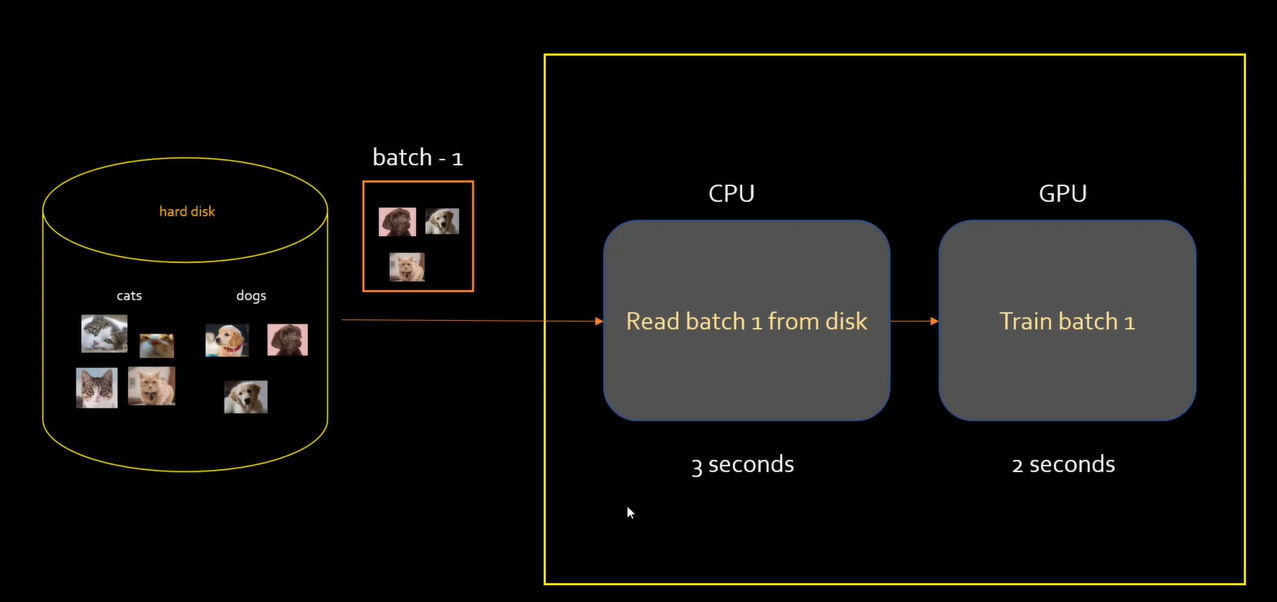

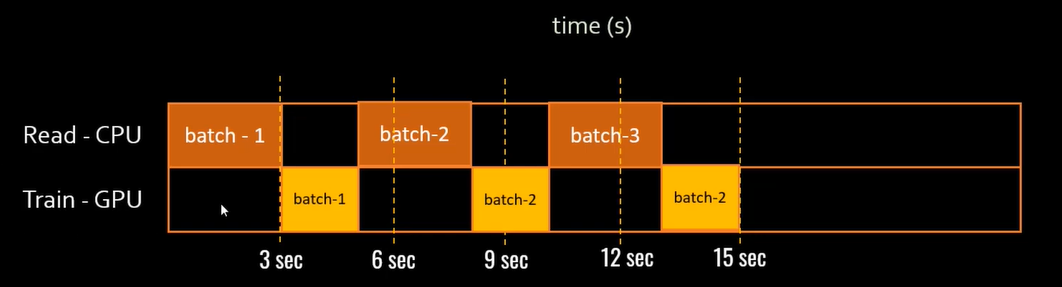

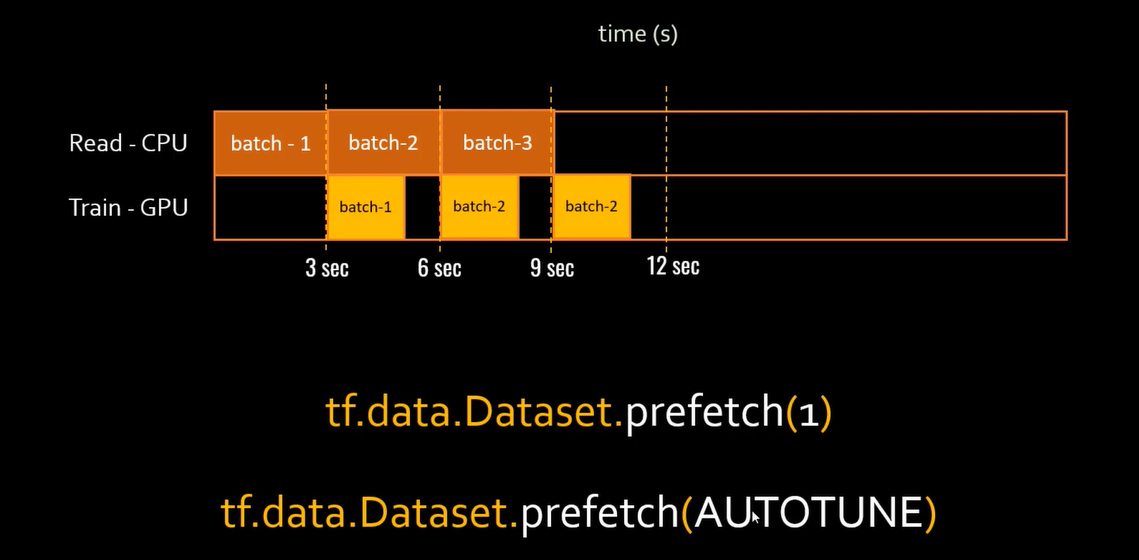

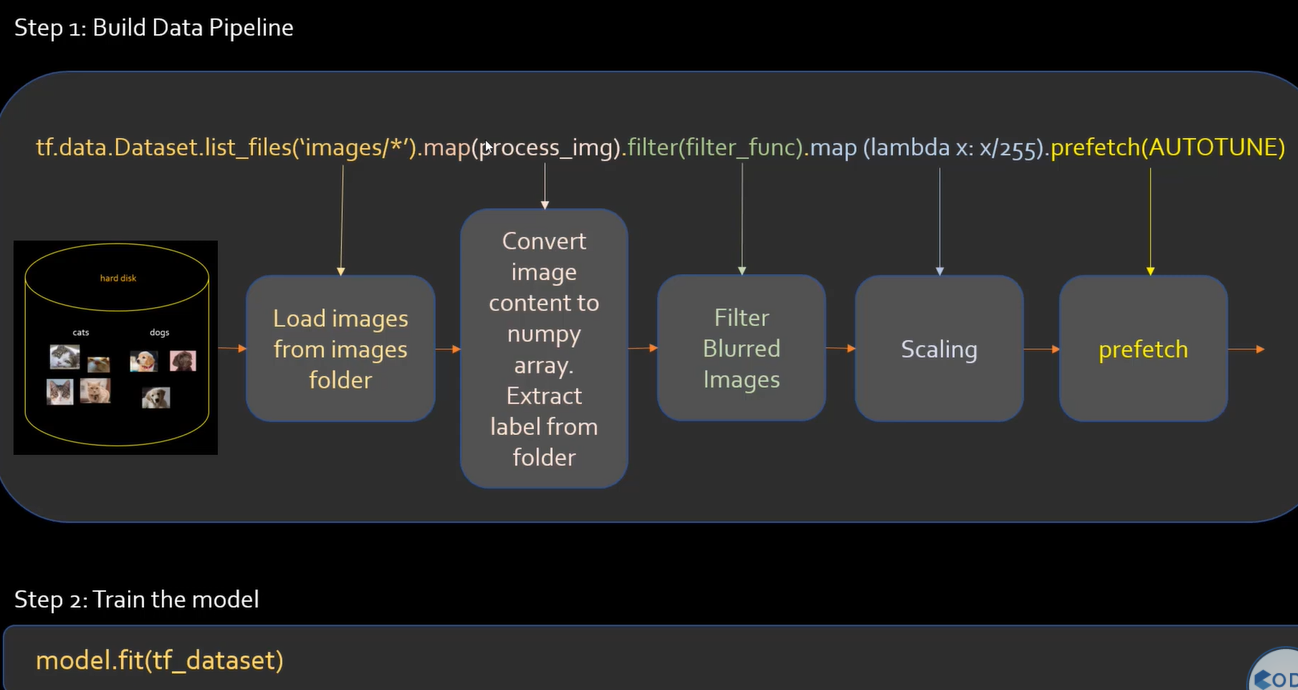

The problem here is that for each epoch, the tf.data.Dataset pipeline will execute each time which is a redundancy problem. To tackle this problem, we using caching.

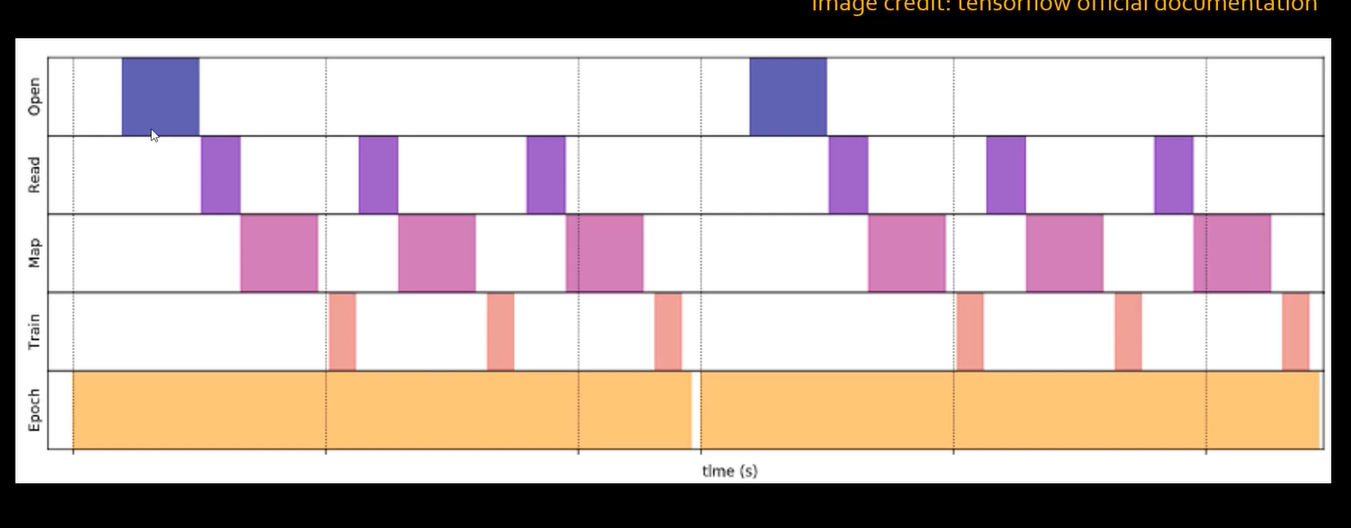

open, read and map are reduntant and useless functions for the 2nd epoch and onwards.

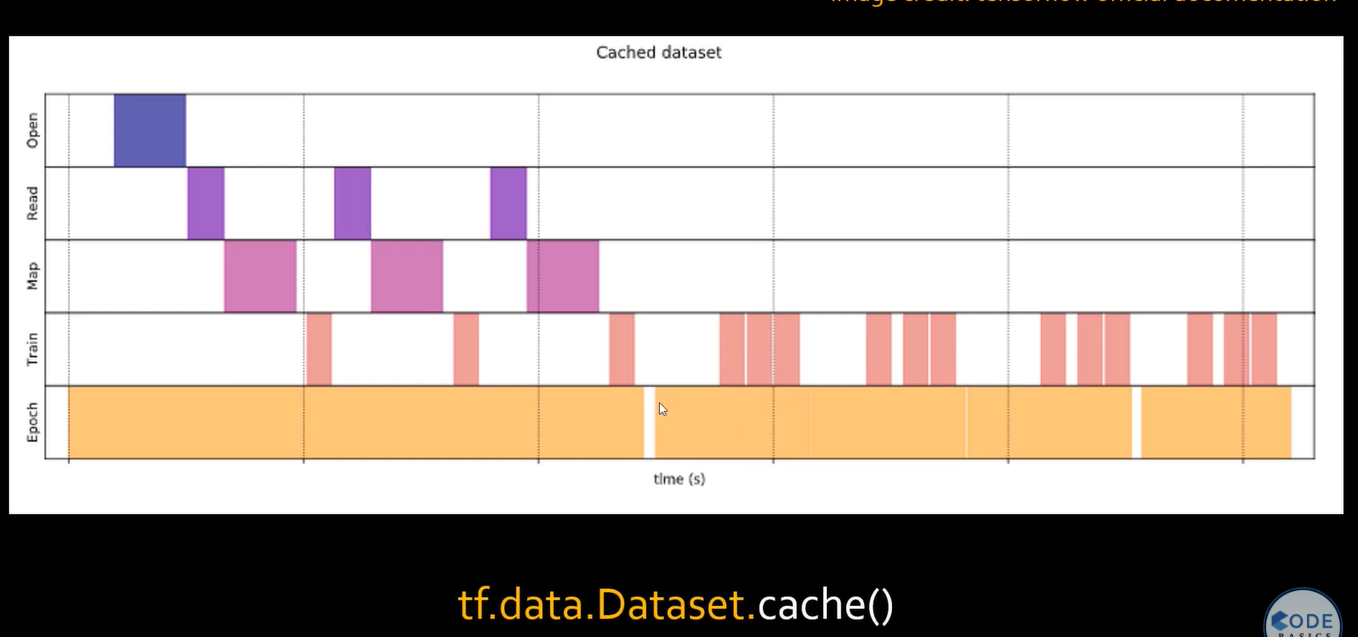

In [8]:
import tensorflow as tf
import time

In [9]:
tf.__version__

'2.17.0'

Prefetch

In [10]:
class FileDataset(tf.data.Dataset):
    def read_file_in_batches(num_samples):
        # Opening the file
        time.sleep(0.03)

        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            time.sleep(0.015)

            yield (sample_idx,)

    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls.read_file_in_batches,
            output_signature = tf.TensorSpec(shape = (1,), dtype = tf.int64),
            args=(num_samples,)
        )

In [11]:
def benchmark(dataset, num_epochs=2):
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)

In [12]:
%%timeit
benchmark(FileDataset())

294 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
benchmark(FileDataset().prefetch(1))

286 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
benchmark(FileDataset().prefetch(tf.data.AUTOTUNE))

276 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As you can notice above, using prefetch improves the performance from 294 ms to 286 and 276 ms

Cache

In [15]:
dataset = tf.data.Dataset.range(5)
dataset = dataset.map(lambda x: x**2)
dataset = dataset.cache("mycache.txt")
# The first time reading through the data will generate the data using
# `range` and `map`.
list(dataset.as_numpy_iterator())

[0, 1, 4, 9, 16]

In [16]:
# Subsequent iterations read from the cache.
list(dataset.as_numpy_iterator())

[0, 1, 4, 9, 16]

In [17]:
def mapped_function(s):
    # Do some hard pre-processing
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s

In [18]:
%%timeit -r1 -n1
benchmark(FileDataset().map(mapped_function), 5)

1.27 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
%%timeit -r1 -n1
benchmark(FileDataset().map(mapped_function).cache(), 5)

438 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Further reading https://www.tensorflow.org/guide/data_performance#caching